In [ ]:
# | default_exp estimation
import jax

jax.config.update("jax_enable_x64", True)

# Maximum Likelihood Estimation
> See also the corresponding [section in my thesis](https://stefanheyder.github.io/dissertation/thesis.pdf#nameddest=section.3.7)

In [ ]:
# | export
import jax.numpy as jnp
import jax.random as jrn
from jax import vmap
from jaxtyping import Float, Array, PRNGKeyArray
from isssm.kalman import kalman
from jax import jit
from scipy.optimize import minimize as minimize_scipy
from isssm.laplace_approximation import laplace_approximation
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling,
)
from isssm.importance_sampling import normalize_weights
from isssm.typing import GLSSM, PGSSM

In [ ]:
# | hide
import jax
from isssm.glssm import simulate_glssm
import tensorflow_probability.substrates.jax.distributions as tfd
import fastcore.test as fct
from isssm.pgssm import simulate_pgssm, nb_pgssm_running_example
from isssm.models.glssm import lcm

## Gaussian linear models

For [GLSSMs](./00_glssm.ipynb) we can evaluate the likelihood analytically with a single pass of the Kalman filter.
Based on the predictions $\hat Y_{t| t - 1}$ and associated covariance matrices $\Psi_{t + 1 | t}$ for $t = 0, \dots n$ produced by the Kalman filter we can derive the gaussian negative log- likelihood which is given by the gaussian distribution with that mean and covariance matrix and observation $Y_t$. 

In [ ]:
# | export
from isssm.util import MVN_degenerate as MVN

vmm = vmap(jnp.matmul, (0, 0))


@jit
def gnll(
    y: Float[Array, "n+1 p"],  # observations $y_t$
    x_pred: Float[Array, "n+1 m"],  # predicted states $\hat X_{t+1\bar t}$
    Xi_pred: Float[Array, "n+1 m m"],  # predicted state covariances $\Xi_{t+1\bar t}$
    B: Float[Array, "n+1 p m"],  # state observation matrices $B_{t}$
    Omega: Float[Array, "n+1 p p"],  # observation covariances $\Omega_{t}$
) -> Float:  # gaussian negative log-likelihood
    """Gaussian negative log-likelihood"""
    y_pred = vmm(B, x_pred)
    Psi_pred = vmm(vmm(B, Xi_pred), jnp.transpose(B, (0, 2, 1))) + Omega

    return -MVN(y_pred, Psi_pred).log_prob(y).sum()


@jit
def gnll_full(y: Float[Array, "n+1 p"], model: GLSSM):  # observations $y_t$
    filtered = kalman(y, model)
    return gnll(y, filtered.x_pred, filtered.Xi_pred, model.B, model.Omega)

In [ ]:
# | hide

glssm_model = lcm(1, 0.0, 1.0, 1.0, 1.0)
_, (y,) = simulate_glssm(glssm_model, 1, jrn.PRNGKey(34234))

x_filt, Xi_filt, x_pred, Xi_pred = kalman(y, glssm_model)
nll = gnll_full(y, glssm_model)


EY = jnp.zeros((2,))
CovY = jnp.array([[2.0, 1.0], [1.0, 3.0]])

fct.test_eq(
    nll, -tfd.MultivariateNormalFullCovariance(EY, CovY).log_prob(y.reshape(-1))
)

## MLE in GLSSMs

For a parametrized GLSSM, that is a model that depends on parameters $\theta$, we can use numerical optimization to find the maximum likelihood estimatior.

::: {.callout-caution}
With these methods, the user has to take care that they provide a parametrization that is unconstrained, i.e. using $\log$ transformations for positive parameters.
:::

::: {.callout-note}
## Implementation Details

1. For low dimensional state space models obtaining the gradient of the negative log likelihood may be feasible by automatic differentiation, in this case use the `mle_glssm_ad` method. Otherwise the derivative free Nelder-Mead method in `mle_glssm` may be favorable.
2. To stabilize numerical results we minimize $\frac{1}{(n + 1)p} \log_{\theta} p(y)$ instead of $\log p_\theta (y)$.
:::

In [ ]:
# | export
from scipy.optimize import minimize as minimize_scipy
from jax.scipy.optimize import minimize as minimize_jax
from scipy.optimize import OptimizeResult
from jax.scipy.optimize import OptimizeResults


def mle_glssm(
    y: Float[Array, "n+1 p"],  # observations $y_t$
    model_fn,  # parameterize GLSSM
    theta0: Float[Array, "k"],  # initial parameter guess
    aux,  # auxiliary data for the model
    options=None,  # options for the optimizer
) -> OptimizeResult:  # result of MLE optimization
    """Maximum likelihood estimation for GLSSM"""

    @jit
    def f(theta: Float[Array, "k"]) -> Float:
        model = model_fn(theta, aux)
        # improve numerical stability by dividing by number of observations
        n_obs = y.size
        return gnll_full(y, model) / n_obs

    return minimize_scipy(f, theta0, method="BFGS", options=options)


def mle_glssm_ad(
    y: Float[Array, "n+1 p"],  # observations $y_t$
    model_fn,  # parameterize GLSSM
    theta0: Float[Array, "k"],  # initial parameter guess
    aux,  # auxiliary data for the model
    options=None,  # options for the optimizer
) -> OptimizeResults:  # result of MLE optimization
    """Maximum likelihood estimation for GLSSM using automatic differentiation"""

    def f(theta: Float[Array, "k"]) -> Float:
        model = model_fn(theta, aux)
        # improve numerical stability by dividing by number of observations
        n_obs = y.size
        return gnll_full(y, model) / n_obs

    return minimize_jax(f, theta0, method="BFGS", options=options)

In [ ]:
def parameterized_lcm(theta, aux):
    log_s2_eps, log_s2_eta = theta
    n, x0, s2_x0 = aux

    return lcm(n, x0, s2_x0, jnp.exp(log_s2_eps), jnp.exp(log_s2_eta))


theta = jnp.log(jnp.array([2.0, 3.0]))
aux = (100, 0.0, 1.0)
true_model = parameterized_lcm(theta, aux)
_, (y,) = simulate_glssm(true_model, 1, jrn.PRNGKey(15435324))

# start far away from true parameter
result_bfgs = mle_glssm(
    y, parameterized_lcm, 2 * jnp.ones(2), aux, options={"return_all": True}
)
result_ad = mle_glssm_ad(y, parameterized_lcm, 2 * jnp.ones(2), aux)

result_bfgs.x - result_ad.x

Array([ 1.86792884e-05, -9.92347117e-06], dtype=float64)

In [ ]:
#| hide
%timeit mle_glssm(y, parameterized_lcm, 2 * jnp.ones(2), aux)
%timeit mle_glssm_ad(y, parameterized_lcm, 2 * jnp.ones(2), aux)

80.7 ms ± 3.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
789 ms ± 43.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Numerical differentiation is much faster here, and as accurate as automatic differentiation. 

In [ ]:
import matplotlib.pyplot as plt

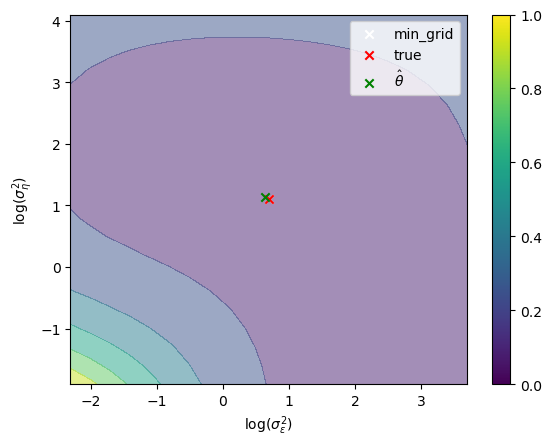

In [ ]:
# 2d grid on the log scale
k = 21  # number of evaluations in each dimension
log_s2_eps, log_s2_eta = jnp.meshgrid(
    jnp.linspace(-3, 3, k) + theta[0], jnp.linspace(-3, 3, k) + theta[1]
)
# flatten
thetas = jnp.vstack([log_s2_eps.ravel(), log_s2_eta.ravel()]).T


def gnll_theta(theta):
    return gnll_full(y, parameterized_lcm(theta, aux))


nlls = vmap(gnll_theta)(thetas)
# location of minium in nlls
i = jnp.argmin(nlls)
# location of minimum in the grid
i_eps, i_eta = i // 21, i % 21

plt.contourf(log_s2_eps, log_s2_eta, nlls.reshape(k, k), alpha=0.5)
plt.scatter(
    log_s2_eps[i_eps, i_eta],
    log_s2_eta[i_eps, i_eta],
    c="white",
    marker="x",
    label="min_grid",
)
plt.scatter(theta[0], theta[1], c="r", marker="x", label="true")
plt.scatter(*result_bfgs.x, c="g", marker="x", label="$\\hat\\theta$")
plt.legend()
plt.xlabel("$\\log(\\sigma^2_\\varepsilon)$")
plt.ylabel("$\\log(\\sigma^2_\\eta)$")
plt.colorbar()
plt.show()

## Inference for Log-Concave State Space Models

For non-gaussian state space models we cannot evaluate the likelihood analytically but resort to simulation methods, more specifically [importance sampling](40_importance_sampling.ipynb). 

Importance Sampling is performed using a surrogate gaussian model that shares the state density $g(x) = p(x)$ and is parameterized by synthetic observations $z$ and their covariance matrices $\Omega$. In this surrogate model the likeilhood $\ell_g = g(z)$ and posterior distribution $g(x|z)$ are tractable and we can [simulate from the posterior](10_kalman_filter_smoother#Sampling_from_the_smoothing_distribution).

Having obtained $N$ independent samples $X^i, i= 1, \dots, N$ from this surrogate posterior we can evaluate the likelihood $\ell$ by Monte-Carlo integration:

$$
\begin{align*}
p(y) &= \int p(x, y) \,\mathrm dx \\
    &=\int \frac{p(x,y)}{g(x|z)} g(x|z) \,\mathrm dx \\
    &= g(z) \int \frac{p(y|x)}{g(z|x)} g(x|z)\,\mathrm dx \\
    &\approx g(z) \frac 1 N \sum_{i =1}^N w(X^i) 
\end{align*}
$$

where $w(X^i) = \frac{p\left(y|X^i\right)}{g\left(z|X^i\right)}$ are the unnormalized importance sampling weights. 
Additionally, we use the bias correction term $ \frac{s^2_w}{2 N \bar w^2}$ from [@Durbin1997Monte], where $s^2_w$ is the empirical variance of the weights and $\bar w$ is their mean.

In total we estimate the negative log-likelihood by

$$
- \log p(y) \approx \ell_g - \log \left(\sum_{i=1}^N w(X^i) \right) + \log N - \frac{s^{2}_{w}}{2 N \bar w^{2}}
$$

::: {.callout-note}
### Implementation Details

1. Similar to MLE in GLSSMs, we minimize $-\frac{1}{(n + 1)p} \log p(y)$ instead of $-\log p(y)$.
:::

In [ ]:
# |export
from jax.scipy.special import logsumexp
from isssm.importance_sampling import pgssm_importance_sampling
from isssm.kalman import kalman
from isssm.typing import GLSSM, PGSSM


def _pgnll(
    gnll: Float,  # surrogate gaussian negative log-likelihood
    unnormalized_log_weights: Float[
        Array, "N"
    ],  # unnormalized log-weights $\log w(X^i)$
) -> Float:  # the approximate negative log-likelihood
    """Internal Log-Concave Negative Log-Likelihood"""
    (N,) = unnormalized_log_weights.shape
    weights = normalize_weights(unnormalized_log_weights)
    return (
        gnll - logsumexp(unnormalized_log_weights) + jnp.log(N)
    )  # - (jnp.var(weights) / (2 * N * jnp.mean(weights) ** 2))


def pgnll(
    y: Float[Array, "n+1 p"],  # observations
    model: PGSSM,  # the model
    z: Float[Array, "n+1 p"],  # synthetic observations
    Omega: Float[Array, "n+1 p p"],  # covariance of synthetic observations
    N: int,  # number of samples
    key: PRNGKeyArray,  # random key
) -> Float:  # the approximate negative log-likelihood
    """Log-Concave Negative Log-Likelihood"""

    key, subkey = jrn.split(key)

    _, log_weights = pgssm_importance_sampling(y, model, z, Omega, N, subkey)

    return _pgnll(
        gnll_full(
            z,
            GLSSM(
                model.u,
                model.A,
                model.D,
                model.Sigma0,
                model.Sigma,
                model.v,
                model.B,
                Omega,
            ),
        ),
        log_weights,
    )

In [ ]:
# | hide
fct.test_close(_pgnll(0.0, jnp.array([0.0, 0.0])), 0.0)

To perform maximum likelihood estimation in a parameterized log-concave state space model we have to evaluate the likelihood several times. For evaluating the likelihood at $\theta$ we have to perform the following:

1. Find a surrogate Gaussian model $g(x,z)$ for $p_\theta(x,y)$ (e.g. [Laplace approximation](30_laplace_approximation.ipynb) or [efficient importance sampling](50_modified_efficient_importance_sampling.ipynb)).
2. Generate [importance samples](40_importance_sampling.ipynb) from these models using the [Kalman smoother](10_kalman_filter_smoother.ipynb).
3. Approximate the negative log likelihood using the methods of this module.

This makes maximum likelihood an intensive task for these kinds of models.

For an initial guess we optimize the approximatie loglikelihood with the weights component fixed at the mode, see Eq. (21) in[@Durbin1997Monte] for further details. 

In [ ]:
# | export
from isssm.importance_sampling import log_weights
from isssm.laplace_approximation import posterior_mode


def initial_theta(
    y: Float[Array, "n+1 p"],  # observations $y_t$
    model_fn,  # parameterized PGSSM
    theta0: Float[Array, "k"],  # initial parameter guess
    aux,  # auxiliary data for the model
    n_iter_la: int,  # number of LA iterations
    options=None,  # options for the optimizer
):
    """Initial value for Maximum Likelihood Estimation for PGSSMs"""

    @jit
    def f(theta):
        model = model_fn(theta, aux)

        proposal, info = laplace_approximation(y, model, n_iter_la)

        u, A, D, Sigma0, Sigma, v, B, Omega, z = proposal
        glssm_la = GLSSM(u, A, D, Sigma0, Sigma, v, B, Omega)

        signal = posterior_mode(proposal)
        _, _, x_pred, Xi_pred = kalman(z, glssm_la)

        negloglik = (
            gnll(z, x_pred, Xi_pred, B, Omega)
            - log_weights(signal, y, model.dist, model.xi, z, Omega).sum()
        )
        # improve numerical stability by dividing by number of observations
        n_obs = y.size
        return negloglik / n_obs

    result = minimize_scipy(f, theta0, method="BFGS", options=options)
    return result

As an example consider a parameterized version of the [running example](20_lcssm.ipynb#running) with unknown parameters $\sigma^2_\varepsilon$ and $r$.

In [ ]:
def model_fn(theta, aux) -> PGSSM:
    log_s2_eps, log_r = theta

    n, x0 = aux

    r = jnp.exp(log_r)
    s2_eps = jnp.exp(log_s2_eps)
    return nb_pgssm_running_example(
        s_order=0,
        Sigma0_seasonal=jnp.eye(0),
        x0_seasonal=jnp.zeros(0),
        s2_speed=s2_eps,
        r=r,
        n=n,
    )


n = 100
theta_lc = jnp.array([jnp.log(1), jnp.log(20.0)])
aux = (n, jnp.ones(2))
model = model_fn(theta_lc, aux)
key = jrn.PRNGKey(512)
key, subkey = jrn.split(key)
_, (y,) = simulate_pgssm(model, 1, subkey)
theta_lc

Array([0.        , 2.99573227], dtype=float64)

In [ ]:
initial_result = initial_theta(y, model_fn, theta_lc, aux, 10)
theta0 = initial_result.x
initial_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.6582279916185756
        x: [ 3.517e-01  2.924e+00]
      nit: 19
      jac: [ 8.717e-07 -3.055e-07]
 hess_inv: [[ 2.940e+01  1.136e+02]
            [ 1.136e+02  2.929e+03]]
     nfev: 63
     njev: 21

In [ ]:
# | export
def mle_pgssm(
    y: Float[Array, "n+1 p"],  # observations $y_t$
    model_fn,  # parameterized LCSSM
    theta0: Float[Array, "k"],  # initial parameter guess
    aux,  # auxiliary data for the model
    n_iter_la: int,  # number of LA iterations
    N: int,  # number of importance samples
    key: Array,  # random key
    options=None,  # options for the optimizer
) -> Float[Array, "k"]:  # MLE
    """Maximum Likelihood Estimation for PGSSMs"""

    @jit
    def f(theta, key):
        model = model_fn(theta, aux)

        propsal_la, _ = laplace_approximation(y, model, n_iter_la)

        key, subkey = jrn.split(key)
        proposal_meis, _ = modified_efficient_importance_sampling(
            y, model, propsal_la.z, propsal_la.Omega, n_iter_la, N, subkey
        )

        key, subkey = jrn.split(key)
        # improve numerical stability by dividing by number of observations
        n_obs = y.size
        return pgnll(y, model, proposal_meis.z, proposal_meis.Omega, N, subkey) / n_obs

    key, subkey = jrn.split(key)
    result = minimize_scipy(f, theta0, method="BFGS", options=options, args=(subkey,))
    return result

In [ ]:
key, subkey = jrn.split(key)
result = mle_pgssm(y, model_fn, theta0, aux, 10, 1000, subkey)
theta_hat = result.x
result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.6555639902860129
        x: [ 4.324e-01  3.704e+00]
      nit: 22
      jac: [-3.512e-05 -3.926e-06]
 hess_inv: [[ 2.199e+00 -1.947e+01]
            [-1.947e+01  1.724e+02]]
     nfev: 291
     njev: 94

In [ ]:
@jit
def pgnll_full(theta, key):
    model = model_fn(theta, aux)

    proposal, info = laplace_approximation(y, model, 10)
    key, subkey = jrn.split(key)
    proposal_meis, _ = modified_efficient_importance_sampling(
        y, model, proposal.z, proposal.Omega, 10, 100, subkey
    )

    key, subkey = jrn.split(key)
    return pgnll(y, model, proposal_meis.z, proposal_meis.Omega, 100, subkey) / y.size

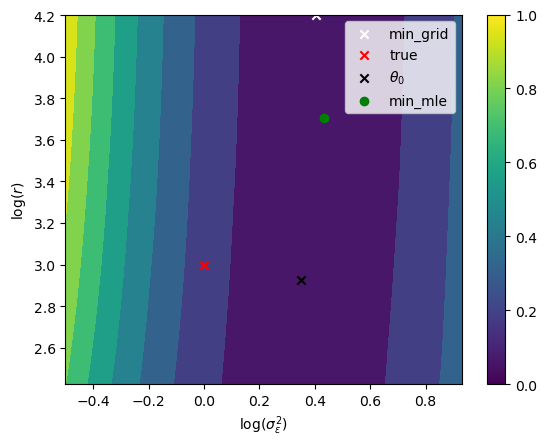

In [ ]:
# 2d grid on the log scale
(log_sigma_min, log_r_min), (log_sigma_max, log_r_max) = jnp.min(
    jnp.vstack((theta_lc, theta0, theta_hat)), axis=0
), jnp.max(jnp.vstack((theta_lc, theta0, theta_hat)), axis=0)
k = 20  # number of evaluations in each dimension
delta = 0.5
log_sigma, log_r = jnp.meshgrid(
    jnp.linspace(log_sigma_min - delta, log_sigma_max + delta, k),
    jnp.linspace(log_r_min - delta, log_r_max + delta, k),
)
# flatten
thetas = jnp.vstack([log_sigma.ravel(), log_r.ravel()]).T

key, subkey = jrn.split(key)
nlls = vmap(pgnll_full, (0, None))(thetas, subkey)
# location of minimum in nlls
i = jnp.argmin(nlls)
# location of minimum in the grid
i_sigma, i_r = i // k, i % k

plt.contourf(log_sigma, log_r, nlls.reshape(k, k))
plt.scatter(
    log_sigma[i_sigma, i_r],
    log_r[i_sigma, i_r],
    c="white",
    marker="x",
    label="min_grid",
)
plt.scatter(theta_lc[0], theta_lc[1], c="r", marker="x", label="true")
plt.scatter(theta0[0], theta0[1], c="black", marker="x", label="$\\theta_0$")
plt.scatter(*theta_hat, c="g", marker="o", label="min_mle")
plt.legend()
plt.xlabel("$\\log(\\sigma^2_\\varepsilon)$")
plt.ylabel("$\\log(r)$")
plt.colorbar()
plt.show()

From the above picture, we see that $\log r$ is hard to determine: the likelihood is very flat in the $r$ direction, which explains the precision loss warning in the optimizer. Nevertheless, our estimate $\hat\theta$ seems to have converged to a reasonable value.

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()